In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.7 MB 10 kB/s 
     |████████████████████████████████| 17.3 MB 97 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.

In [2]:
!rm -rf tcc
!git clone https://github.com/matheussn/tcc.git
%cd tcc

Cloning into 'tcc'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 356 (delta 165), reused 279 (delta 91), pack-reused 0
Receiving objects: 100% (356/356), 38.13 MiB | 36.59 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/tcc


In [3]:
!rm -rf mmsegmentation
!git clone -b v0.20.2 https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6023, done.
remote: Counting objects: 100% (529/529), done.
remote: Compressing objects: 100% (358/358), done.
remote: Total 6023 (delta 277), reused 298 (delta 166), pack-reused 5494
Receiving objects: 100% (6023/6023), 12.59 MiB | 31.51 MiB/s, done.
Resolving deltas: 100% (4346/4346), done.
Note: checking out '991b0512b9f4835275957e4c4896b5f4c4696eac'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

/content/tcc/mmsegmentation
Obtaining file:///content/tcc/mmsegmentation
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.20.2


In [5]:
!rm -rf segmentation/
!unzip ../../segmentation.zip

Archive:  ../../segmentation.zip
   creating: segmentation/
   creating: segmentation/annotations/
  inflating: segmentation/annotations/image020-roi1.tif  
  inflating: segmentation/annotations/image008-roi1.tif  
  inflating: segmentation/annotations/image032-roi1.tif  
  inflating: segmentation/annotations/image019-roi2.tif  
  inflating: segmentation/annotations/image019-roi5.tif  
  inflating: segmentation/annotations/image058-roi5.tif  
  inflating: segmentation/annotations/image038-roi4.tif  
  inflating: segmentation/annotations/image058-roi1.tif  
  inflating: segmentation/annotations/image021-roi3.tif  
  inflating: segmentation/annotations/image006-roi2.tif  
  inflating: segmentation/annotations/image021-roi6.tif  
  inflating: segmentation/annotations/image038-roi1.tif  
  inflating: segmentation/annotations/image003-2-roi3.tif  
  inflating: segmentation/annotations/image038-roi3.tif  
  inflating: segmentation/annotations/image039-roi3.tif  
  inflating: segmentation/ann

In [6]:
data_root = 'segmentation'
img_dir = 'images'
ann_dir = 'annotations'

In [7]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

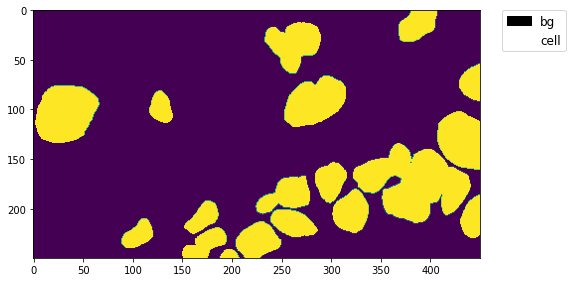

In [8]:
# Let's take a look at the segmentation map we got

img = Image.open('segmentation/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [9]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [10]:
@DATASETS.register_module()
class DysplasiaDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [11]:
cfg = Config.fromfile('../models/pspnet.py')

In [12]:
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [13]:
datasets = [build_dataset(cfg.data.train)]

2022-02-14 21:02:00,926 - mmseg - INFO - Loaded 96 images


In [14]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

/content/tcc/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '


In [15]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-02-14 21:02:06,719 - mmseg - INFO - Loaded 24 images
2022-02-14 21:02:06,752 - mmseg - INFO - Start running, host: root@542210cacd50, work_dir: /content/tcc/mmsegmentation/work_dirs/psp
2022-02-14 21:02:06,760 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 13.1 task/s, elapsed: 2s, ETA:     0s

2022-02-14 21:02:18,132 - mmseg - INFO - per class results:
2022-02-14 21:02:18,137 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.32 | 100.0 |
|  cell |  0.0  |  0.0  |
+-------+-------+-------+
2022-02-14 21:02:18,142 - mmseg - INFO - Summary:
2022-02-14 21:02:18,147 - mmseg - INFO - 
+------+-------+------+
| aAcc | mDice | mAcc |
+------+-------+------+
| 71.4 | 41.66 | 50.0 |
+------+-------+------+
2022-02-14 21:02:18,151 - mmseg - INFO - Epoch(val) [1][24]	aAcc: 0.7140, mDice: 0.4166, mAcc: 0.5000, Dice.bg: 0.8332, Dice.cell: 0.0000, Acc.bg: 1.0000, Acc.cell: 0.0000
2022-02-14 21:02:27,313 - mmseg - INFO - Epoch [2][12/12]	lr: 9.553e-03, eta: 0:02:46, time: 0.759, data_time: 0.226, memory: 3768, decode.loss_ce: 0.5112, decode.acc_seg: 48.5380, aux.loss_ce: 0.1981, aux.acc_seg: 49.9354, loss: 0.7093


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 26.0 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:02:28,249 - mmseg - INFO - per class results:
2022-02-14 21:02:28,252 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.32 | 100.0 |
|  cell |  0.0  |  0.0  |
+-------+-------+-------+
2022-02-14 21:02:28,254 - mmseg - INFO - Summary:
2022-02-14 21:02:28,256 - mmseg - INFO - 
+------+-------+------+
| aAcc | mDice | mAcc |
+------+-------+------+
| 71.4 | 41.66 | 50.0 |
+------+-------+------+
2022-02-14 21:02:28,258 - mmseg - INFO - Epoch(val) [2][24]	aAcc: 0.7140, mDice: 0.4166, mAcc: 0.5000, Dice.bg: 0.8332, Dice.cell: 0.0000, Acc.bg: 1.0000, Acc.cell: 0.0000
2022-02-14 21:02:36,931 - mmseg - INFO - Epoch [3][12/12]	lr: 9.104e-03, eta: 0:02:33, time: 0.718, data_time: 0.189, memory: 3768, decode.loss_ce: 0.5197, decode.acc_seg: 52.5965, aux.loss_ce: 0.2023, aux.acc_seg: 53.5014, loss: 0.7220


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 26.6 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:02:37,842 - mmseg - INFO - per class results:
2022-02-14 21:02:37,846 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.15 | 96.83 |
|  cell | 16.91 |  9.97 |
+-------+-------+-------+
2022-02-14 21:02:37,848 - mmseg - INFO - Summary:
2022-02-14 21:02:37,852 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 71.99 | 50.03 | 53.4 |
+-------+-------+------+
2022-02-14 21:02:37,855 - mmseg - INFO - Epoch(val) [3][24]	aAcc: 0.7199, mDice: 0.5003, mAcc: 0.5340, Dice.bg: 0.8315, Dice.cell: 0.1691, Acc.bg: 0.9683, Acc.cell: 0.0997
2022-02-14 21:02:46,590 - mmseg - INFO - Epoch [4][12/12]	lr: 8.653e-03, eta: 0:02:23, time: 0.723, data_time: 0.194, memory: 3768, decode.loss_ce: 0.4875, decode.acc_seg: 53.2697, aux.loss_ce: 0.1925, aux.acc_seg: 54.4086, loss: 0.6799


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 25.4 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:02:47,545 - mmseg - INFO - per class results:
2022-02-14 21:02:47,547 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.61 | 98.56 |
|  cell | 12.85 |  7.11 |
+-------+-------+-------+
2022-02-14 21:02:47,549 - mmseg - INFO - Summary:
2022-02-14 21:02:47,557 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 72.41 | 48.23 | 52.84 |
+-------+-------+-------+
2022-02-14 21:02:47,561 - mmseg - INFO - Epoch(val) [4][24]	aAcc: 0.7241, mDice: 0.4823, mAcc: 0.5284, Dice.bg: 0.8361, Dice.cell: 0.1285, Acc.bg: 0.9856, Acc.cell: 0.0711
2022-02-14 21:02:56,319 - mmseg - INFO - Epoch [5][12/12]	lr: 8.199e-03, eta: 0:02:13, time: 0.725, data_time: 0.192, memory: 3768, decode.loss_ce: 0.4613, decode.acc_seg: 54.4689, aux.loss_ce: 0.1813, aux.acc_seg: 55.2902, loss: 0.6426


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.4 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:02:57,202 - mmseg - INFO - per class results:
2022-02-14 21:02:57,204 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.41 | 96.91 |
|  cell |  29.1 | 18.34 |
+-------+-------+-------+
2022-02-14 21:02:57,209 - mmseg - INFO - Summary:
2022-02-14 21:02:57,211 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 74.44 | 56.76 | 57.63 |
+-------+-------+-------+
2022-02-14 21:02:57,215 - mmseg - INFO - Epoch(val) [5][24]	aAcc: 0.7444, mDice: 0.5676, mAcc: 0.5763, Dice.bg: 0.8441, Dice.cell: 0.2910, Acc.bg: 0.9691, Acc.cell: 0.1834
2022-02-14 21:03:06,017 - mmseg - INFO - Epoch [6][12/12]	lr: 7.742e-03, eta: 0:02:04, time: 0.729, data_time: 0.193, memory: 3768, decode.loss_ce: 0.4478, decode.acc_seg: 56.9310, aux.loss_ce: 0.1772, aux.acc_seg: 57.3042, loss: 0.6250


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 26.3 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:03:06,942 - mmseg - INFO - per class results:
2022-02-14 21:03:06,944 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.93 | 94.75 |
|  cell |  41.0 | 29.16 |
+-------+-------+-------+
2022-02-14 21:03:06,947 - mmseg - INFO - Summary:
2022-02-14 21:03:06,949 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 76.0 | 62.96 | 61.96 |
+------+-------+-------+
2022-02-14 21:03:06,953 - mmseg - INFO - Epoch(val) [6][24]	aAcc: 0.7600, mDice: 0.6296, mAcc: 0.6196, Dice.bg: 0.8493, Dice.cell: 0.4100, Acc.bg: 0.9475, Acc.cell: 0.2916
2022-02-14 21:03:15,765 - mmseg - INFO - Epoch [7][12/12]	lr: 7.282e-03, eta: 0:01:55, time: 0.729, data_time: 0.190, memory: 3768, decode.loss_ce: 0.4177, decode.acc_seg: 57.9233, aux.loss_ce: 0.1662, aux.acc_seg: 58.2062, loss: 0.5839


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 26.7 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:03:16,671 - mmseg - INFO - per class results:
2022-02-14 21:03:16,673 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.79 | 89.61 |
|  cell | 53.24 | 45.68 |
+-------+-------+-------+
2022-02-14 21:03:16,674 - mmseg - INFO - Summary:
2022-02-14 21:03:16,677 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.05 | 69.01 | 67.65 |
+-------+-------+-------+
2022-02-14 21:03:16,681 - mmseg - INFO - Epoch(val) [7][24]	aAcc: 0.7705, mDice: 0.6901, mAcc: 0.6765, Dice.bg: 0.8479, Dice.cell: 0.5324, Acc.bg: 0.8961, Acc.cell: 0.4568
2022-02-14 21:03:25,729 - mmseg - INFO - Epoch [8][12/12]	lr: 6.818e-03, eta: 0:01:46, time: 0.749, data_time: 0.206, memory: 3768, decode.loss_ce: 0.3910, decode.acc_seg: 54.5129, aux.loss_ce: 0.1563, aux.acc_seg: 54.7763, loss: 0.5473


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.5 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:03:26,612 - mmseg - INFO - per class results:
2022-02-14 21:03:26,613 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.93 | 89.05 |
|  cell | 55.14 | 48.47 |
+-------+-------+-------+
2022-02-14 21:03:26,615 - mmseg - INFO - Summary:
2022-02-14 21:03:26,622 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.44 | 70.04 | 68.76 |
+-------+-------+-------+
2022-02-14 21:03:26,624 - mmseg - INFO - Epoch(val) [8][24]	aAcc: 0.7744, mDice: 0.7004, mAcc: 0.6876, Dice.bg: 0.8493, Dice.cell: 0.5514, Acc.bg: 0.8905, Acc.cell: 0.4847
2022-02-14 21:03:35,467 - mmseg - INFO - Epoch [9][12/12]	lr: 6.351e-03, eta: 0:01:37, time: 0.732, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3915, decode.acc_seg: 57.6277, aux.loss_ce: 0.1579, aux.acc_seg: 57.7266, loss: 0.5494


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.1 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:03:36,332 - mmseg - INFO - per class results:
2022-02-14 21:03:36,333 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.89 | 86.94 |
|  cell | 58.89 | 55.34 |
+-------+-------+-------+
2022-02-14 21:03:36,336 - mmseg - INFO - Summary:
2022-02-14 21:03:36,343 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 77.9 | 71.89 | 71.14 |
+------+-------+-------+
2022-02-14 21:03:36,347 - mmseg - INFO - Epoch(val) [9][24]	aAcc: 0.7790, mDice: 0.7189, mAcc: 0.7114, Dice.bg: 0.8489, Dice.cell: 0.5889, Acc.bg: 0.8694, Acc.cell: 0.5534
2022-02-14 21:03:45,239 - mmseg - INFO - Epoch [10][12/12]	lr: 5.880e-03, eta: 0:01:28, time: 0.736, data_time: 0.191, memory: 3768, decode.loss_ce: 0.4065, decode.acc_seg: 58.3751, aux.loss_ce: 0.1637, aux.acc_seg: 58.2314, loss: 0.5703
2022-02-14 21:03:45,242 - mmseg - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 24.1 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:03:48,877 - mmseg - INFO - per class results:
2022-02-14 21:03:48,878 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.88 |  82.8 |
|  cell |  61.5 | 63.47 |
+-------+-------+-------+
2022-02-14 21:03:48,879 - mmseg - INFO - Summary:
2022-02-14 21:03:48,882 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.27 | 72.69 | 73.14 |
+-------+-------+-------+
2022-02-14 21:03:48,891 - mmseg - INFO - Epoch(val) [10][24]	aAcc: 0.7727, mDice: 0.7269, mAcc: 0.7314, Dice.bg: 0.8388, Dice.cell: 0.6150, Acc.bg: 0.8280, Acc.cell: 0.6347
2022-02-14 21:03:57,821 - mmseg - INFO - Epoch [11][12/12]	lr: 5.405e-03, eta: 0:01:19, time: 0.739, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3962, decode.acc_seg: 61.0737, aux.loss_ce: 0.1604, aux.acc_seg: 60.8035, loss: 0.5566


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.6 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:03:58,700 - mmseg - INFO - per class results:
2022-02-14 21:03:58,702 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.7 | 87.47 |
|  cell | 61.59 | 58.42 |
+-------+-------+-------+
2022-02-14 21:03:58,703 - mmseg - INFO - Summary:
2022-02-14 21:03:58,706 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.16 | 73.65 | 72.95 |
+-------+-------+-------+
2022-02-14 21:03:58,711 - mmseg - INFO - Epoch(val) [11][24]	aAcc: 0.7916, mDice: 0.7365, mAcc: 0.7295, Dice.bg: 0.8570, Dice.cell: 0.6159, Acc.bg: 0.8747, Acc.cell: 0.5842
2022-02-14 21:04:07,875 - mmseg - INFO - Epoch [12][12/12]	lr: 4.925e-03, eta: 0:01:11, time: 0.758, data_time: 0.206, memory: 3768, decode.loss_ce: 0.4228, decode.acc_seg: 66.0195, aux.loss_ce: 0.1675, aux.acc_seg: 66.3101, loss: 0.5903


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.7 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:04:08,748 - mmseg - INFO - per class results:
2022-02-14 21:04:08,751 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.85 | 82.76 |
|  cell | 61.47 | 63.46 |
+-------+-------+-------+
2022-02-14 21:04:08,752 - mmseg - INFO - Summary:
2022-02-14 21:04:08,755 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.24 | 72.66 | 73.11 |
+-------+-------+-------+
2022-02-14 21:04:08,763 - mmseg - INFO - Epoch(val) [12][24]	aAcc: 0.7724, mDice: 0.7266, mAcc: 0.7311, Dice.bg: 0.8385, Dice.cell: 0.6147, Acc.bg: 0.8276, Acc.cell: 0.6346
2022-02-14 21:04:17,749 - mmseg - INFO - Epoch [13][12/12]	lr: 4.440e-03, eta: 0:01:02, time: 0.744, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3900, decode.acc_seg: 60.7570, aux.loss_ce: 0.1582, aux.acc_seg: 60.6476, loss: 0.5482


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.3 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:04:18,634 - mmseg - INFO - per class results:
2022-02-14 21:04:18,636 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.37 | 84.83 |
|  cell | 64.27 | 65.28 |
+-------+-------+-------+
2022-02-14 21:04:18,643 - mmseg - INFO - Summary:
2022-02-14 21:04:18,644 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.24 | 74.82 | 75.06 |
+-------+-------+-------+
2022-02-14 21:04:18,650 - mmseg - INFO - Epoch(val) [13][24]	aAcc: 0.7924, mDice: 0.7482, mAcc: 0.7506, Dice.bg: 0.8537, Dice.cell: 0.6427, Acc.bg: 0.8483, Acc.cell: 0.6528
2022-02-14 21:04:27,581 - mmseg - INFO - Epoch [14][12/12]	lr: 3.949e-03, eta: 0:00:53, time: 0.740, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3762, decode.acc_seg: 61.0904, aux.loss_ce: 0.1523, aux.acc_seg: 60.9483, loss: 0.5285


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.8 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:04:28,454 - mmseg - INFO - per class results:
2022-02-14 21:04:28,456 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.47 | 81.61 |
|  cell | 65.46 | 70.99 |
+-------+-------+-------+
2022-02-14 21:04:28,460 - mmseg - INFO - Summary:
2022-02-14 21:04:28,463 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 78.58 | 74.97 | 76.3 |
+-------+-------+------+
2022-02-14 21:04:28,468 - mmseg - INFO - Epoch(val) [14][24]	aAcc: 0.7858, mDice: 0.7497, mAcc: 0.7630, Dice.bg: 0.8447, Dice.cell: 0.6546, Acc.bg: 0.8161, Acc.cell: 0.7099
2022-02-14 21:04:37,429 - mmseg - INFO - Epoch [15][12/12]	lr: 3.450e-03, eta: 0:00:44, time: 0.742, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3535, decode.acc_seg: 58.2725, aux.loss_ce: 0.1411, aux.acc_seg: 58.4254, loss: 0.4946


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.4 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:04:38,315 - mmseg - INFO - per class results:
2022-02-14 21:04:38,317 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.79 | 85.41 |
|  cell | 65.07 | 65.79 |
+-------+-------+-------+
2022-02-14 21:04:38,318 - mmseg - INFO - Summary:
2022-02-14 21:04:38,321 - mmseg - INFO - 
+------+-------+------+
| aAcc | mDice | mAcc |
+------+-------+------+
| 79.8 | 75.43 | 75.6 |
+------+-------+------+
2022-02-14 21:04:38,329 - mmseg - INFO - Epoch(val) [15][24]	aAcc: 0.7980, mDice: 0.7543, mAcc: 0.7560, Dice.bg: 0.8579, Dice.cell: 0.6507, Acc.bg: 0.8541, Acc.cell: 0.6579
2022-02-14 21:04:47,284 - mmseg - INFO - Epoch [16][12/12]	lr: 2.943e-03, eta: 0:00:35, time: 0.741, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3674, decode.acc_seg: 62.5245, aux.loss_ce: 0.1518, aux.acc_seg: 61.8474, loss: 0.5191


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.6 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:04:48,160 - mmseg - INFO - per class results:
2022-02-14 21:04:48,162 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.74 | 86.06 |
|  cell | 63.94 | 63.36 |
+-------+-------+-------+
2022-02-14 21:04:48,164 - mmseg - INFO - Summary:
2022-02-14 21:04:48,165 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.56 | 74.84 | 74.71 |
+-------+-------+-------+
2022-02-14 21:04:48,170 - mmseg - INFO - Epoch(val) [16][24]	aAcc: 0.7956, mDice: 0.7484, mAcc: 0.7471, Dice.bg: 0.8574, Dice.cell: 0.6394, Acc.bg: 0.8606, Acc.cell: 0.6336
2022-02-14 21:04:57,180 - mmseg - INFO - Epoch [17][12/12]	lr: 2.426e-03, eta: 0:00:26, time: 0.746, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3610, decode.acc_seg: 61.0713, aux.loss_ce: 0.1467, aux.acc_seg: 60.8786, loss: 0.5076


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 26.8 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:04:58,086 - mmseg - INFO - per class results:
2022-02-14 21:04:58,088 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.53 | 84.39 |
|  cell |  65.5 | 67.69 |
+-------+-------+-------+
2022-02-14 21:04:58,090 - mmseg - INFO - Summary:
2022-02-14 21:04:58,096 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.61 | 75.52 | 76.04 |
+-------+-------+-------+
2022-02-14 21:04:58,102 - mmseg - INFO - Epoch(val) [17][24]	aAcc: 0.7961, mDice: 0.7552, mAcc: 0.7604, Dice.bg: 0.8553, Dice.cell: 0.6550, Acc.bg: 0.8439, Acc.cell: 0.6769
2022-02-14 21:05:07,111 - mmseg - INFO - Epoch [18][12/12]	lr: 1.895e-03, eta: 0:00:17, time: 0.746, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3720, decode.acc_seg: 63.8442, aux.loss_ce: 0.1523, aux.acc_seg: 63.3997, loss: 0.5242


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.4 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:05:07,996 - mmseg - INFO - per class results:
2022-02-14 21:05:07,998 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.97 |  85.5 |
|  cell | 65.63 | 66.53 |
+-------+-------+-------+
2022-02-14 21:05:08,000 - mmseg - INFO - Summary:
2022-02-14 21:05:08,003 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.07 |  75.8 | 76.01 |
+-------+-------+-------+
2022-02-14 21:05:08,007 - mmseg - INFO - Epoch(val) [18][24]	aAcc: 0.8007, mDice: 0.7580, mAcc: 0.7601, Dice.bg: 0.8597, Dice.cell: 0.6563, Acc.bg: 0.8550, Acc.cell: 0.6653
2022-02-14 21:05:17,023 - mmseg - INFO - Epoch [19][12/12]	lr: 1.346e-03, eta: 0:00:08, time: 0.746, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3523, decode.acc_seg: 61.6370, aux.loss_ce: 0.1470, aux.acc_seg: 60.7999, loss: 0.4993


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 26.7 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:05:17,933 - mmseg - INFO - per class results:
2022-02-14 21:05:17,937 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.35 | 83.77 |
|  cell |  65.7 | 68.75 |
+-------+-------+-------+
2022-02-14 21:05:17,938 - mmseg - INFO - Summary:
2022-02-14 21:05:17,940 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.47 | 75.53 | 76.26 |
+-------+-------+-------+
2022-02-14 21:05:17,943 - mmseg - INFO - Epoch(val) [19][24]	aAcc: 0.7947, mDice: 0.7553, mAcc: 0.7626, Dice.bg: 0.8535, Dice.cell: 0.6570, Acc.bg: 0.8377, Acc.cell: 0.6875
2022-02-14 21:05:27,031 - mmseg - INFO - Epoch [20][12/12]	lr: 7.679e-04, eta: 0:00:00, time: 0.752, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3591, decode.acc_seg: 60.4154, aux.loss_ce: 0.1483, aux.acc_seg: 59.8278, loss: 0.5074
2022-02-14 21:05:27,033 - mmseg - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 22.0 task/s, elapsed: 1s, ETA:     0s

2022-02-14 21:05:30,395 - mmseg - INFO - per class results:
2022-02-14 21:05:30,397 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.28 | 83.46 |
|  cell | 65.87 | 69.39 |
+-------+-------+-------+
2022-02-14 21:05:30,398 - mmseg - INFO - Summary:
2022-02-14 21:05:30,401 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.44 | 75.58 | 76.43 |
+-------+-------+-------+
2022-02-14 21:05:30,406 - mmseg - INFO - Epoch(val) [20][24]	aAcc: 0.7944, mDice: 0.7558, mAcc: 0.7643, Dice.bg: 0.8528, Dice.cell: 0.6587, Acc.bg: 0.8346, Acc.cell: 0.6939


/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

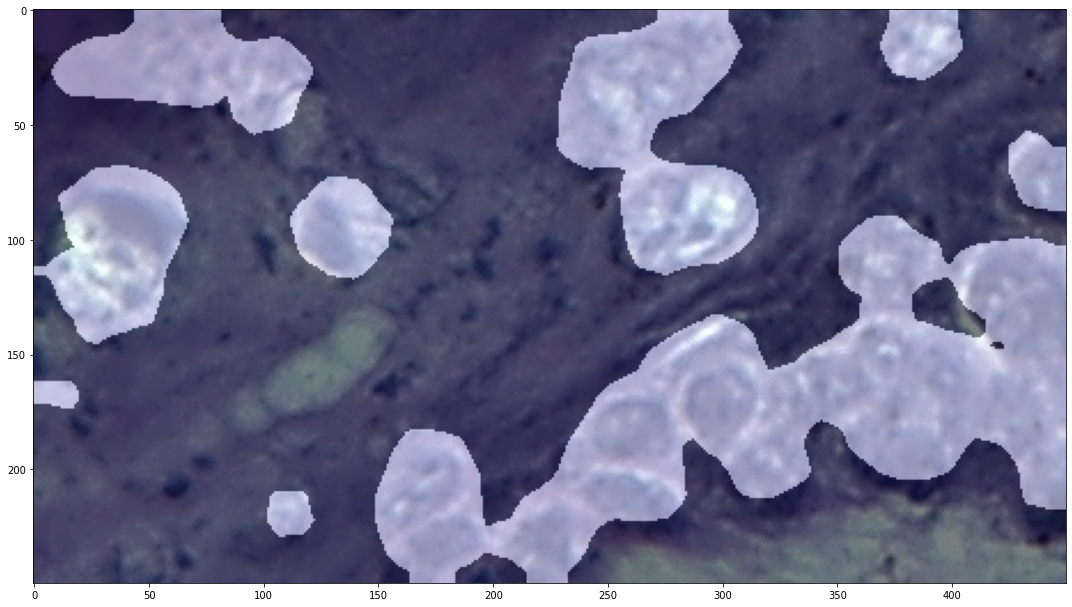

In [17]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image003-2-roi1.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

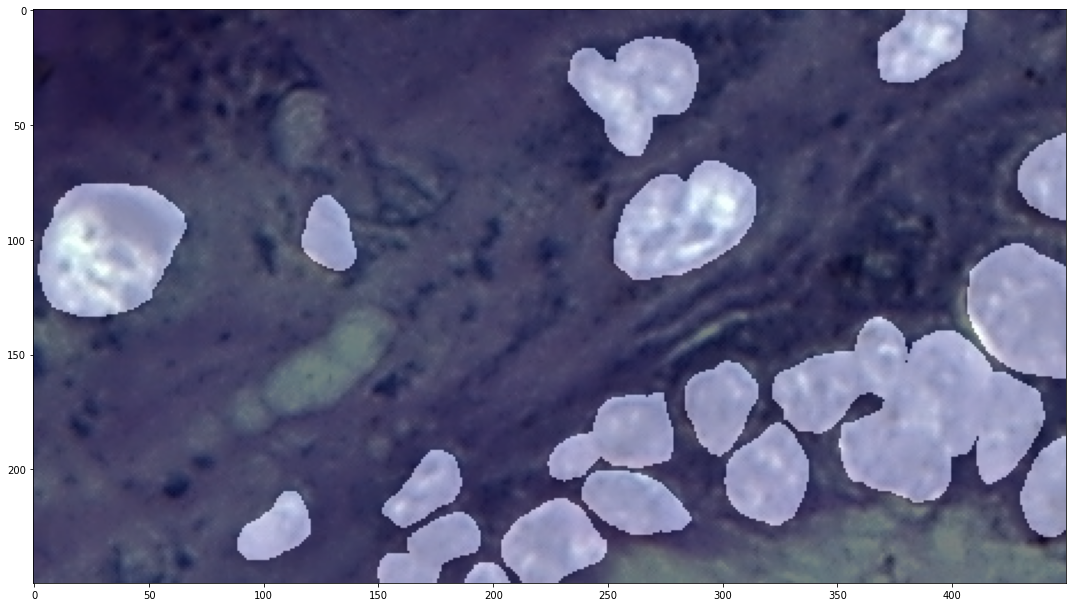

In [18]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image003-2-roi1.jpg')
result = mmcv.imread('segmentation/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
# result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

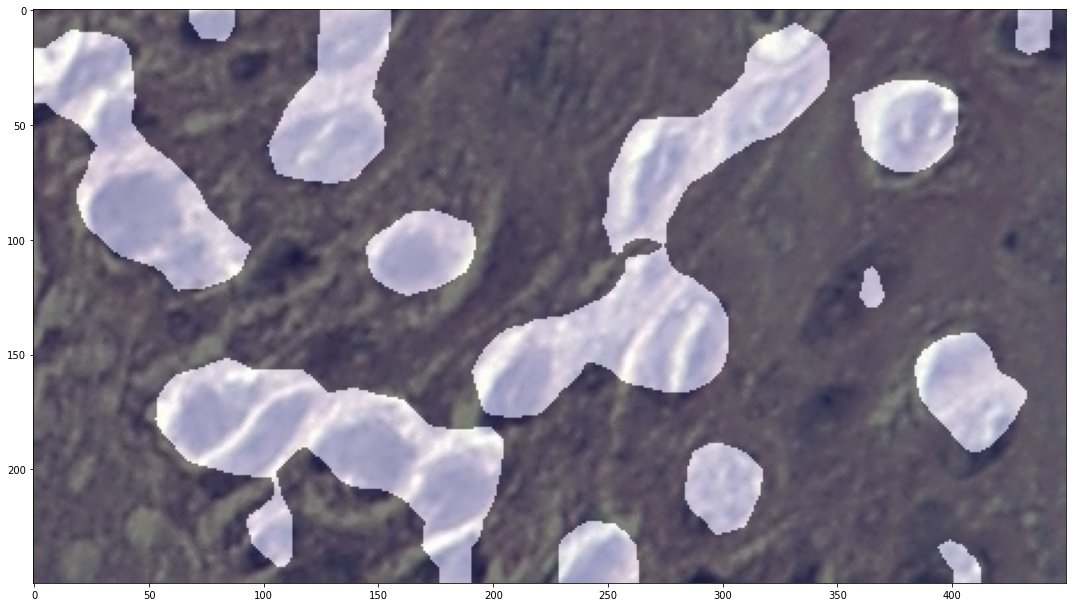

In [19]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image037-roi4.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

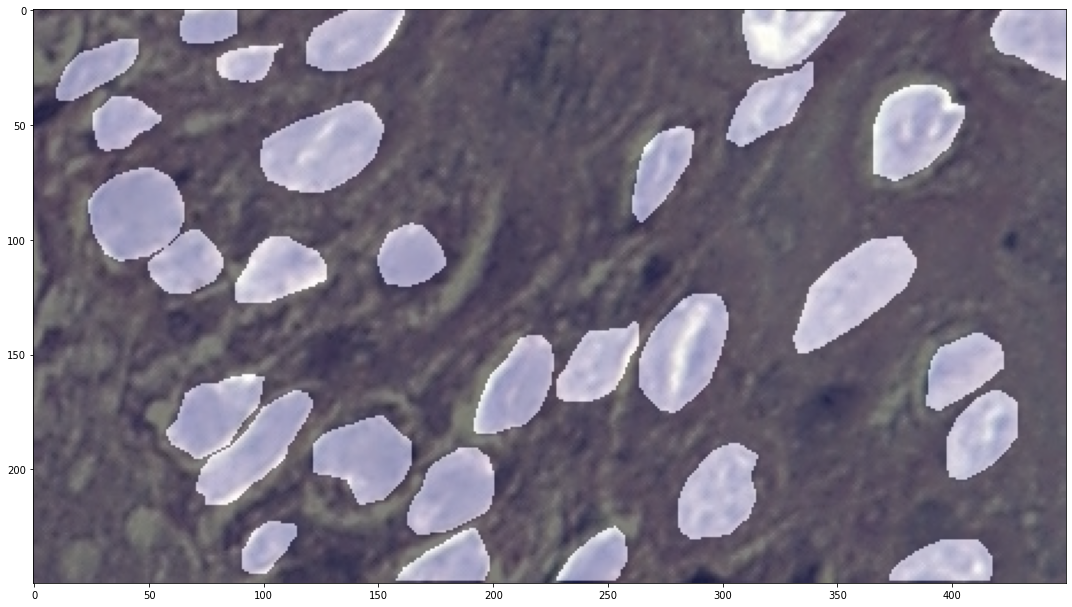

In [20]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image037-roi4.jpg')
result = mmcv.imread('segmentation/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
# result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

In [21]:
%matplotlib inline
import json

file = open('./work_dirs/psp/None.log.json')
lines = file.readlines()

m_dice = []
m_acc = []
loss = []

for line in lines:
    json_line = json.loads(line)
    if len(json_line):
        if json_line['mode'] == 'train':
            loss.append(json_line['loss'])
        else:
            m_acc.append(json_line['mAcc'])
            m_dice.append(json_line['mDice'])

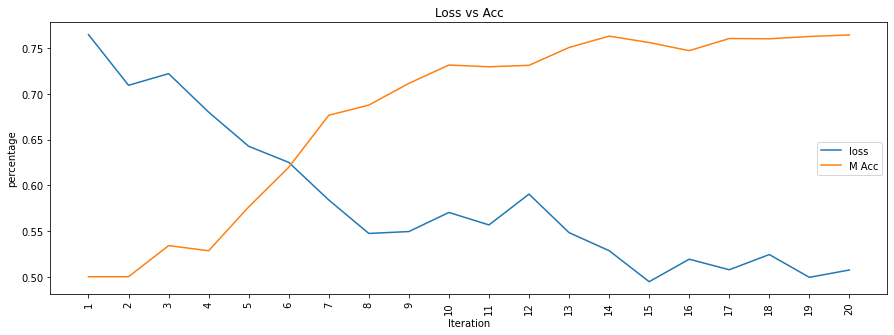

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), loss, label="loss")
plt.plot(range(1, len(m_acc) + 1), m_acc, label="M Acc")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("Loss vs Acc")
plt.xlabel("Iteration")
plt.ylabel("percentage")
plt.legend()
plt.savefig('Loss_vs_Acc_Graph.png')
plt.show()

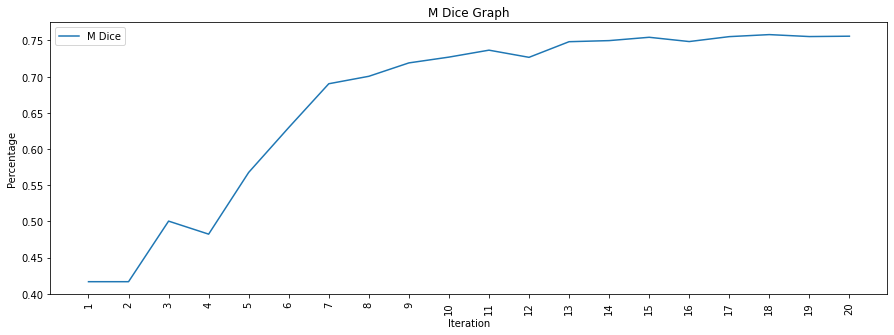

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), m_dice, label="M Dice")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("M Dice Graph")
plt.xlabel("Iteration")
plt.ylabel("Percentage")
plt.legend()
plt.savefig('M_Dice_Graph.png')
plt.show()
plt.close()